In [2]:
import torch
import torch.nn as nn
from torch.distributions import normal
from torch.distributions import uniform
import matplotlib.pyplot as plt

DEVICE = 'cuda:0'

In [3]:
torch.manual_seed(1)
class CUDAvoir(nn.Module):
    def __init__(self,n,p,sig,o=0.0,bias=True):
        super(CUDAvoir,self).__init__()

        self.n = torch.tensor(n)
        self.p = torch.tensor(p)
        self.sig = torch.tensor(sig)

        self.v = torch.zeros(self.n).to(DEVICE) ## Recurrent Layer State Vector
        self.w = torch.zeros(self.n,self.n) ## Recurrent Layer Weight Matrix

        self.ol = nn.Linear(self.n, 1, bias=False) ## Linear Output Layer
        self.o = torch.tensor([o]).to(DEVICE) ## Initalize Output Neuron
        self.fb = nn.Linear(1, self.n, bias=False) ## Linear Feedback Layer
        self.fb.weight.requires_grad_(False)

        if bias: ## Recurrent Layer Bias
            self.b = torch.FloatTensor(n).uniform_(0,1)
        else:
            self.b = torch.zeros(self.n)
        
        ## Populate Recurrent Layer Weight Matrix
        norm = normal.Normal(loc=0,scale=self.sig)
        uni = uniform.Uniform(0,1) 
        for i in range(self.n):
            for j in range(self.n):
                uni_draw = uni.sample()
                if uni_draw < self.p:
                    self.w[i,j] = norm.sample()
                    
        self.w = torch.tensor(self.w,requires_grad=True).to(DEVICE)
    
    def forward(self):
        z = torch.matmul(self.w.to(DEVICE),self.v.to(DEVICE)).to(DEVICE) + self.fb(self.o) + self.b.to(DEVICE)
        nl = nn.Tanh()
        y = nl(z)
        self.v = y.to(DEVICE)
        self.o = self.ol(y)
        return self.v, self.o

In [16]:
n, p, sig = 30, 0.3, 0.3
m = CUDAvoir(n,p,sig)
m = m.to(DEVICE)

lr = 0.02
targ = torch.sin
dt = 0.05
steps = 1000

targs = []
outs = []


for s in range(steps):
    y,o = m.forward()
    outs.append(o)
    
    diff = o - targ(torch.tensor(dt*s))
    
    targs.append(targ(torch.tensor([dt*s])))
    
    
    
    if s % 2 == 0:
        rms = diff.pow(2)
        rms.backward(retain_graph=True)
        ol = m.ol.weight.detach()
        ol_g = m.ol.weight.grad
        nw = (ol - lr*ol_g).clone().detach()
        m.ol.weight = nn.Parameter(nw)
        
        
       

/home/melander/a/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


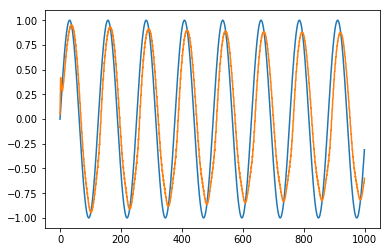

In [17]:
plt.plot(targs)
plt.plot(outs)

In [18]:
steps = 1000


outs = []


for s in range(steps):
    y,o = m.forward()
    outs.append(o)
    


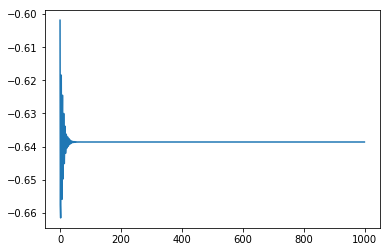

In [19]:
plt.plot(outs)